# ACP sur prénoms

In [181]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Dans Colab faut installer ces packages :

In [ ]:
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install -q git+git://github.com/geopandas/geopandas.git
!pip install -q contextily
!pip install -q mapclassify

In [702]:
import contextily as cx
import mapclassify
import geopandas as gpd

## Importation des données et toilettage.

In [703]:
url = "http://cordier-phychi.toile-libre.org/Info/github/dpt2019.csv"
prenoms_data = pd.read_csv(url,sep=";")

choix :
- on ne s'occupe que des années de 2001 (`y_deb`) à 2019 (`y_fin`)
- on ne garde que les prénoms qui apparaissent au moins 50 (`nb_min`) fois. 

In [704]:
y_deb = 2001
y_fin = 2019
nb_min = 100

In [705]:
prenoms_data = prenoms_data[prenoms_data['preusuel']!='_PRENOMS_RARES']
prenoms_data = prenoms_data[~(prenoms_data['dpt']=="XX")]
prenoms_data['dpt'] = pd.to_numeric(prenoms_data['dpt'])
prenoms_data['annais'] = pd.to_numeric(prenoms_data['annais'])
prenoms_data = prenoms_data[prenoms_data["dpt"]<96]
prenoms_data = prenoms_data[prenoms_data["annais"]>=2001]
cumul_prenoms = prenoms_data.groupby(["preusuel"], as_index=False)["nombre"].agg('sum')
cumul_prenoms = cumul_prenoms[cumul_prenoms["nombre"]>nb_min]
prenoms_data = prenoms_data[prenoms_data['preusuel'].isin(cumul_prenoms['preusuel'])]

In [706]:
départements = pd.unique(prenoms_data["dpt"])
# Attention, la corse est le département 20 dans ces data (pas 2A et 2B)
a = prenoms_data.groupby(["preusuel", "dpt"], as_index=False)["nombre"].sum()
# on somme sur les années par prénom et par département

In [707]:
prénoms = pd.unique(prenoms_data["preusuel"])
print(f"{len(prénoms)} prénoms en tout")

2942 prénoms en tout


Fabrication d'une dataframe avec chaque prénom en colonne et les départements en index.

In [708]:
PRENOMS = pd.DataFrame(index = départements,columns = prénoms)
for i in range(len(a)) :
    dep = a.loc[i, "dpt"]
    pren = a.loc[i, "preusuel"]
    nb = a.loc[i, "nombre"]
    PRENOMS.loc[dep,pren]=nb
PRENOMS = PRENOMS.fillna(0) # NaN -> 0
PRENOMS = PRENOMS.sort_index()
PRENOMS

,AARON,ABD,ABDALLAH,ABDEL,ABDELKADER,ABDELKARIM,ABDELLAH,ABDELMALIK,ABDELRAHMAN,ABDERAHMANE,...,ZEYNEB,ZEYNEP,ZIA,ZINA,ZINEB,ZOE,ZOÉ,ZOË,ZOHRA,ZOLA
1,147,0,7,0,0,0,0,0,0,0,...,3,17,0,0,3,9,253,0,0,0
2,213,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,21,504,0,0,0
3,125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,246,0,0,0
4,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,38,0,0,0
5,40,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7,97,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,565,0,88,10,9,0,3,3,0,0,...,15,61,6,10,29,25,666,0,8,3
92,774,19,215,44,44,6,71,3,10,3,...,26,3,11,18,89,71,1256,6,30,0
93,643,33,335,98,109,23,94,12,33,34,...,92,113,0,42,130,6,481,0,85,0
94,742,3,162,26,44,0,27,6,3,6,...,17,21,0,3,44,62,654,0,31,0


## Traitement statistique

On standardise les données (centrées réduites).

In [709]:
scaler = StandardScaler()
X = scaler.fit_transform(PRENOMS)

On opère l'ACP :

In [710]:
pca = PCA()
components = pca.fit_transform(X)

In [717]:
taille = 30 #exp_var_cumul.shape[0] + 1
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
fig = px.bar(x=range(1, taille+1),y=pca.explained_variance_ratio_[:taille],labels={"x": "composante", "y": "% variance expliquée"},template="none")
fig.add_scatter(x=list(range(1, taille+1)), y=exp_var_cumul[:taille], name="", showlegend=False)

On va garder 15 composantes :

In [718]:
nb_c = 15
pca = PCA(n_components = nb_c)
pca.fit(X)
score_pca = pca.transform(X)

In [719]:
PRENOMS[[f"composante {i}" for i in range(1,nb_c+1)]] = pd.DataFrame(score_pca, index=PRENOMS.index)
PRENOMS.head(3)

,AARON,ABD,ABDALLAH,ABDEL,ABDELKADER,ABDELKARIM,ABDELLAH,ABDELMALIK,ABDELRAHMAN,ABDERAHMANE,...,composante 6,composante 7,composante 8,composante 9,composante 10,composante 11,composante 12,composante 13,composante 14,composante 15
1,147,0,7,0,0,0,0,0,0,0,...,4.904170,0.627323,-1.864113,0.022727,0.007959,-0.028706,-0.489888,-0.331315,-0.464141,-0.707771
2,213,0,0,0,0,0,0,0,0,0,...,1.251518,-1.647001,0.716498,-2.234743,-2.010880,-1.966772,-1.149985,-1.747221,2.652145,1.802088
3,125,0,0,0,0,0,0,0,0,0,...,0.127462,1.254370,0.263988,-0.665953,-0.830650,-0.476038,-1.022303,-0.039688,0.285303,-0.171851


In [720]:
decomp = pd.DataFrame(pca.components_.T, columns=[f"composante {i}" for i in range(1,nb_c+1)], index=PRENOMS.columns.values[:-nb_c])
decomp

,composante 1,composante 2,composante 3,composante 4,composante 5,composante 6,composante 7,composante 8,composante 9,composante 10,composante 11,composante 12,composante 13,composante 14,composante 15
AARON,0.024015,0.004143,0.004144,0.010984,0.006290,-0.008191,-0.020284,0.003989,-0.012996,-0.000120,-0.001490,-0.004113,-0.015975,-0.005477,0.003826
ABD,0.017777,-0.010667,-0.015103,0.031208,-0.009673,0.010674,0.053574,-0.009021,0.017447,-0.039982,-0.005384,-0.002190,0.002042,0.008347,0.027480
ABDALLAH,0.021639,-0.007107,-0.024735,0.001429,0.004410,0.005924,0.032529,0.017916,0.002680,-0.009908,-0.009708,-0.004893,0.018293,-0.001215,0.010934
ABDEL,0.020640,-0.010718,-0.021151,0.010441,-0.008467,-0.002415,0.039064,-0.013006,0.017598,-0.025287,0.003398,-0.003688,0.016510,0.012652,0.016085
ABDELKADER,0.020154,-0.003842,-0.026425,0.020619,-0.016500,-0.014444,0.016860,-0.015498,0.011023,-0.003844,0.015668,-0.007069,0.026069,0.005066,0.017825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZOE,0.015740,0.008345,0.014384,0.027580,-0.021507,-0.013575,-0.043758,-0.016552,-0.005913,-0.019247,0.020337,-0.013307,0.083600,-0.003329,0.044890
ZOÉ,0.020762,0.023036,0.017805,-0.005954,0.008413,0.013783,-0.006931,0.001943,0.004636,-0.007560,0.008972,0.000740,-0.013214,0.020817,0.003425
ZOË,0.015661,0.025482,0.019922,-0.024200,-0.014648,-0.009060,0.003207,-0.012417,0.007098,0.007881,0.005943,-0.000081,0.020523,-0.005150,-0.004001
ZOHRA,0.022572,-0.004048,-0.018021,0.002311,-0.010355,-0.002523,0.026906,-0.017962,0.013838,-0.017868,-0.004857,-0.006371,0.016142,-0.004050,0.015054


Fonction permettant l'affichage des premiers et derniers prénoms sur une composante donnée :

In [722]:
def recap(composante) :
    i_comp = composante
    nb_prenoms = 100
    indices = indices = [i+j*100 for j in range(4) for i in range(10)]
    tab_recap = pd.DataFrame(index = indices,columns = ["premiers","valeur+","derniers","valeur-"])
    tri_haut = decomp.sort_values(by= f"composante {i_comp}",ascending=False)
    tri_bas = decomp.sort_values(by= f"composante {i_comp}",ascending=True)
    for i in indices :
        tab_recap.loc[i,"premiers"] = tri_haut.index[i]
        tab_recap.loc[i,"valeur+"] = tri_haut.iloc[i,i_comp-1]
        tab_recap.loc[i,"derniers"] = tri_bas.index[i]
        tab_recap.loc[i,"valeur-"] = tri_bas.iloc[i,i_comp-1]
    return tab_recap

## Affichage sur une carte

Récupération et toilettage des données géographiques :

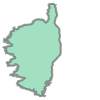

In [723]:
corse = gpd.read_file('http://cordier-phychi.toile-libre.org/Info/github/corse.geojson')
corse['geometry'][0]

In [724]:
dp_data = gpd.read_file('http://cordier-phychi.toile-libre.org/Info/github/departements.geojson')
dp_data.drop(columns='nom',inplace=True)
dp_data.at[28, 'code'] = 20
dp_data.at[28, 'geometry'] = corse['geometry'][0]
dp_data = dp_data[~(dp_data['code']=="2B")]
dp_data['code'] = pd.to_numeric(dp_data['code'])
dp_data = dp_data.sort_values(by="code",ascending=True)
dp_data = dp_data.set_index('code')

In [725]:
PRENOMS_LOC = dp_data.merge(PRENOMS, left_index=True, right_index=True)

In [726]:
def carte_comp(composante) :
    ax = PRENOMS_LOC.plot(figsize = (30,10), alpha=0.8, column = f"composante {composante}", cmap = "viridis", legend=True)
    ax.axis('off')
    return ax

<AxesSubplot:>

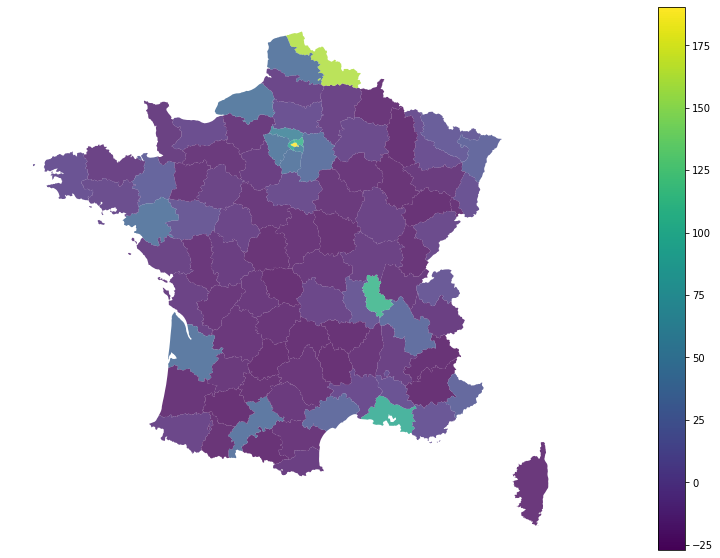

In [729]:
carte_comp(composante = 1)

In [728]:
recap(composante = 1)

,premiers,valeur+,derniers,valeur-
0,SARAH,0.024751,FRANCESCU,-0.001444
1,INÈS,0.024587,PETRU,-0.001444
2,EDEN,0.024433,SAVERIU,-0.001444
3,ISAAC,0.02424,MARC'ANDRIA,-0.001444
4,SANDRA,0.024172,ANGE-MARIE,-0.001444
5,RUBEN,0.024159,SAVERIA,-0.001288
6,ADAM,0.024139,MATTEU,-0.001201
7,ELODIE,0.024093,JORDI,-0.001121
8,SOFIA,0.024055,CHJARA,-0.000978
9,WILLIAM,0.024046,ANDRIA,-0.00097


Valeur d'un prénom donné sur les composantes en places par rapport au max ou au min :

In [730]:
px.bar(decomp.loc['LUC',:])

Carte de la répartition d'un prénom (données standardisées)

In [732]:
PRENOMS_STD = pd.DataFrame(X,columns=PRENOMS.columns[:-nb_c])
PRENOMS_STD.index = range(1,96)
PRENOMS_STD_LOC = dp_data.merge(PRENOMS_STD, left_index=True, right_index=True)

In [733]:
def carte_prenom(prenom) :
    PRENOM = prenom.upper()
    ax = PRENOMS_STD_LOC.plot(figsize = (30,10), alpha=0.8, column = PRENOM, cmap = "viridis", legend=True)
    ax.axis('off')
    return ax

<AxesSubplot:>

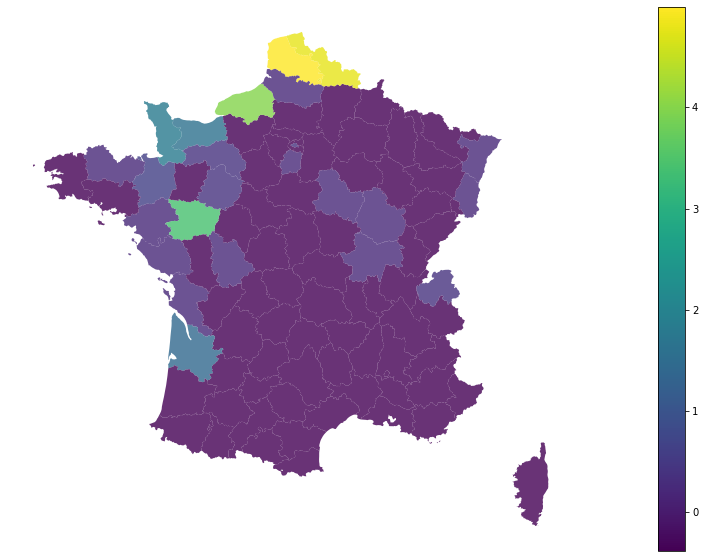

In [741]:
carte_prenom(prenom = 'zola')

Effectifs et répartition d'un prénom :

In [738]:
Prenom = 'zola'.upper()
PRENOMS.sort_values(by=Prenom,ascending=False)[Prenom].head(5)

62    27
59    26
76    22
49    19
50    11
Name: ZOLA, dtype: int64